**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1l9jgkXm-RcvY3SE94cZiP_PYxegAoPDa?usp=sharing)
2. [Практический ноутбук 1](https://colab.research.google.com/drive/1dri4Nx0VNsF9vZmF-qjN12AZBJ-eAdlY?usp=sharing)
3. Практический ноутбук 2


## Загрузка библиотек

In [ ]:
# для измерения времени обучения
import time

# для создания случайных величин
import random

# Импортируем tensorflow
import tensorflow as tf 

# бэкенд Keras
import tensorflow.keras.backend as K 

# функции для детализации и управления процессом обучения
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# функция для отрисовки структуры модели
from tensorflow.keras.utils import plot_model 

# Модули конвертации между RGB и HSV
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb 

# Модули работы с изображениями
from PIL import Image, ImageDraw, ImageFont 

import struct
import gdown

# библиотека numpy
import numpy as np

# Слои нейронной сети
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, Lambda

# Оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# работа со слоями
from tensorflow.keras.layers import add, concatenate

# создание моделей
from tensorflow.keras.models import Model

# загрузчик сохраненных моделей
from tensorflow.keras.models import load_model

# итератор, повторно возвращающий указанный объект 
from itertools import repeat

# регуляризатор, который применяет штраф за регуляризацию L2
from tensorflow.keras.regularizers import l2 

# модуль для отрисовки изображения
from tensorflow.keras.preprocessing import image 

# Функция для отрисовки структуры модели
from tensorflow.keras.utils import plot_model 

# Импортируем tensorflow
import tensorflow as tf 

# gрямоугольник, определяемый точкой привязки xy , а также его шириной и высотой
from matplotlib.patches import Rectangle

# возвращение списка (возможно, пустого) путей, соответствующих шаблону pathname
from glob import glob

# библиотека для работы с файлами
import os

# визуализация 
from matplotlib import pyplot as plt
%matplotlib inline  

Функция ошибки из лекции:

In [ ]:
def yolo_loss(inputs, num_anchors):

    ''' Функция рассчитывает отношение пересечение над объединениеми.
        Args:
            box1 - координаты рамки.
            box2 - координаты рамки.
        Return:
            значение ошибки IoU.
        '''
    # Порог вероятности обнаружения объекта
    ignore_thresh = .5 
    
    # Подсчитываем количество анкоров на каждом уровне сетки
    num_layers = num_anchors // 3 
    
    # Из входных данных выцепляем посчитанные моделью значения
    y_pred = inputs[:num_layers] 
    
    # Из входных данных выцепляем эталонные значения
    y_true = inputs[num_layers:] 
    
    # Задаем маску анкоров для каждого уровня сеток
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] 
   
    # Получаем размерность входного изображения ( (13 х 13) * 32 = (416 х 416)) и приводим к типу элемента y_true[0]
    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0])) 
    
    # Получаем двумерный массив, соответствующий размерностям сеток ((13, 13), (26, 26), (52, 52))
    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    
    loss = 0 # Значение ошибки
    
    # Размер пакета
    m = K.shape(y_pred[0])[0] 

    # Преобразуем к типу y_pred[0]
    batch_size = K.cast(m, K.dtype(y_pred[0])) 
    
    for l in range(num_layers): # Пробегаем по всем трем уровням сеток
       
        # Получаем маску для сетки l-го уровня по вероятности определения объекта (5-ый параметр в списке общих параметров). 
        # В массиве object_mask будут значения, которые соответствуют только вероятности обнаружения объекта
        object_mask = y_true[l][..., 4:5] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        # Получаем аналогичную выборку для сетки l-го уровня с OHE (где записана позиция нашего класса)
        # В массиве true_class будут значения, которые соответсвуют только OHE представлению класса ядля данного уровня анкоров
        true_class = y_true[l][..., 5:] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        num_sub_anchors = len(anchors[anchor_mask[l]]) # Получаем количество анкоров для отдельного уровян сетки (3)
        
        # Решейпим анкоры отдельного уровня сетки и записываем в переменную anchors_tensor
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])
        
        # Создаем двумерный массив grid со значениями [[[0, 0] , [0, 1] , [0, 2] , ... , [0, k]], 
        #                                             [[1, 0] , [1, 1] , [1, 2] , ... , [1 ,k]],
        #                                             ...
        #                                             [[k, 0] , [k, 1] , [k, 2] , ... , [k, k]]]
        # где k - размерность сетки. Массив хранит индексы ячеек сетки
        grid_shape = K.shape(y_pred[l])[1:3] # Получаем ширину и высоту сетки
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1]) # Создаем вертикальную линию
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1]) # Создаем горизонтальную линию
        grid = K.concatenate([grid_x, grid_y]) # Объединяем 
        grid = K.cast(grid, K.dtype(y_pred[l])) # Приводим к типу y_pred[l]
        
        # Решейпим y_pred[l]                 13                13              3              6
        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5]) 
        
        # -- Считаем ошибку в определении координат центра объекта

        # Получаем координаты центра объекта из спредиктенного значения
        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats)) # три точки ... означают, что мы берем все параметры до запятой ,
        # Производим обратные вычесления для оригинальных значений из y_true для координат центра объекта
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid  # Реальные координаты центра bounding_box
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] # чем больше бокс, тем меньше ошибка
        # binary_crossentropy для истинного значения и спредиктенного (obect_mask для подсчета только требуемого значения)
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)

        # --- Считаем ошибку в определении координат ширины и высоты

        # Получаем значения ширины и высоты изображения из спредиктенного значения   
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычесления для оригинальных значений из y_true для ширины и высоты объекта
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1]) 
        # Оставляем значение высоты и ширины только у тех элементов, где object_mask = 1
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh)) 
        # Считаем значение ошибки в определении высоты и ширины
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])
        
        # Объединяем значения в один  массив
        pred_box = K.concatenate([pred_xy, pred_wh]) 
        
        # Считаем ошибку в определении обнаружения какого-либо класса
        # Для этого вначале надо отсечь все найденные объекты, вероятность которых меньше установленного значения ignore_thresh
        
        # Определяем массив, который будет хранить данные о неподходящих значениях
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True) 
        object_mask_bool = K.cast(object_mask, 'bool') # Приводим тип object_mask к типу 'bool'
        
        # Функция, определяющая данные, которые требуется игнорировать
        # Пробегаем по всем элементам пакета (b<m)
        # Получаем параметры реального bounding_box для текущей ячейки
        # Считаем IoU реального и спредиктенного
        # В зависимости от best_iou < ignore_thresh помечаем его как верно распознанный или неверено
        
        def loop_body(b, ignore_mask):

            ''' 
            Функция рассчитывает отношение пересечение над объединениеми.
            Args:
                b - элемент пакета
                ignore_mask - координаты рамки.
            Return:
                b+1 - следующий элемент пакета
                ignore_mask - координаты рамки.
             '''
            
            # в true_box запишутся первыые 4 параметра (центр, высота и ширина объекта) того элемента, значение которого в object_mask_bool равно True
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0]) 
            
            # Подсчитываем iou для спредиктенной ограничивающей рамки (pred_box) и оригинальной (true_box)
            iou = calc_iou(pred_box[b], true_box) 
            
            # Находим лучшую ограничивающую рамку
            best_iou = K.max(iou, axis=-1) 
            
            # Записываем в ignore_mask true или false в зависимости от (best_iou < ignore_thresh)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box))) 
            
            return b+1, ignore_mask  
        
        # Пробегаем в цикле по всем элементам в пределах значения m (m = batch size)
        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask]) 
        ignore_mask = ignore_mask.stack() # Приводим ignore_mask к тензору
        ignore_mask = K.expand_dims(ignore_mask, -1) # Добавляем еще одну размерность в конце ignore_mask
                 
        # Считаем значение ошибки
        # 1 компонента - для значений, которые были верно спредиктены
        # 2 компонентя - для значения, которые были неверно спредиктены
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )
        
        # Считаем ошибку в определении класса объекта
        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)
    
        # Считаем суммарную ошибку
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss
                
    return loss # Возвращаем значение ошибки   

## Новые функции урока функции

In [ ]:
def calc_iou(input1, input2):
    
    ''' Функция подсчета коэффициента пересечения IoU
        Args: 
            input1 -
            input2 -
        Return:
            ошибка IoU 

        '''

    # Добавляем одну размерность
    input1 = K.expand_dims(input1, -2) 
    input2 = K.expand_dims(input2, 0)
    
    # Получаем координаты x,y центра 
    xy1 = input1[..., :2] 
    xy2 = input2[..., :2]

    # Получаем значения высоты и ширины
    wh1 = input1[..., 2:4] 
    wh2 = input2[..., 2:4] 
    
    # Делим значения высоты и ширины пополам
    wh_half1 = wh1 / 2. 
    wh_half2 = wh2 / 2.
    
    # Получаем значение, соответствующее верхнему левому углу
    top_left1 = xy1 - wh_half1 
    top_left2 = xy2 - wh_half2
    
    # Получаем значение, соотвествующее правому нижнему углу
    right_bottom1 = xy1 + wh_half1 
    right_bottom2 = xy2 + wh_half2

    # Берем максимальные координаты из левых верхних углов
    intersect_mins = K.maximum(top_left1, top_left2) 

    # Берем Минимальные координаты координаты из правых нижних углов
    intersect_maxes = K.minimum(right_bottom1, right_bottom2) 
    
    # Считаем ширину и высоту области пересечения
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) 
    
    # Считаем площадь области пересечения
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] 
    
    # Считаем площадь первых элементов
    area1 = wh1[..., 0] * wh1[..., 1] 

    # Считаем площадь вторых элементов
    area2 = wh2[..., 0] * wh2[..., 1] 
    
    return intersect_area / (area1 + area2 - intersect_area) 

In [ ]:
def data_generator(annotation_lines, batch_size, anchors, input_shape):
    
    ''' Функция генерации данных
        Args: 
            annotation_lines -
            batch_size -
            anchors - 
            input_shape -
        Return:
            порция данных для обучения 

        '''

    n = len(annotation_lines) # Получаем количество элементов в словаре аннотаций
    i = 0 # Задаем начальный индекс
    
    while True:
        
        image_data = [] # Массив для хранения изображений 416х416
        box_data = [] # Массив для хранения bounding_box данных
        
        for b in range(batch_size): # Пробегаем по всему batch_size
            
            if i==0: # Если первая итерация цикла
                np.random.shuffle(annotation_lines) # Перемешиваем элементы
            
            # Делаем аугментацию картинок и ограничивающих рамок
            image, box = augmentation(annotation_lines[i]) 
            
            # Добавляем полученную картинку в результирующий массив 
            image_data.append(image) 
            
            # Добавляем полученную ограничивающую рамку в массив bounfing_box
            box_data.append(box) 
            
            # Обновляем значение индека (не превышая общего количества элементов)
            i = (i+1) % n 
        
        # Преобразуем в numpy
        image_data = np.array(image_data)         
        box_data = np.array(box_data) 
        
        # По значению ограничивающей рамки получаем y_true 
        y_true = get_y(box_data, anchors, input_shape)        
        
        yield [image_data, *y_true], np.zeros(batch_size) 

In [ ]:
def augmentation(data):
    
    ''' Функция случайной аугментации данных
        Args: 
            data - изображения 
        Return:
            аугментированные изображение и bounding_box

        '''

    # Словарь с параметрами аугментации
    params = {
        'jitter' : .3,
        'hue'    : .1,
        'sat'    : 1.5,
        'val'    : 1.5
    }
    
    # Сплитим входную строку словаря
    data = data.split() 
    
    # Открываем изображение самолета
    image = Image.open(path + data[0]) 
    
    # Получаем ширину и высоту оригинального изображения
    width_i, height_i = image.size 
    
    # Получаем ширину и высоту входного изображения для модели RetinaNet
    widht_shape, height_shape = input_shape[:2] 
    
    # Получаем координаты ограничивающей рамки
    box = np.array([np.array(list(map(lambda x: int(float(x)),box.split(',')))) for box in data[1:]])
    
    # Случайным образом масштабируем изображение
    new_ar = widht_shape / height_shape * rand(1 - params['jitter'], 1 + params['jitter']) / rand(1 - params['jitter'], 1 + params['jitter'])
    scale = rand(.65, 2) 
    if new_ar < 1:        
        nh = int(scale * height_shape)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * widht_shape)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)
    
    # Преобразуем картинку к input_shape и размещаем случайным образом
    dx = int(rand(0, widht_shape - nw))
    dy = int(rand(0, height_shape - nh))
    new_image = Image.new('RGB', (widht_shape, height_shape), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image
    
    # С вероятностью 50% отображаем по горизонтале
    flip = rand() < .5
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Случайным образом меняем освещенность, экспозицию, гамму изображения
    hue1 = rand(-params['hue'], params['hue'])
    sat1 = rand(1, params['sat']) if rand() < .5 else 1 / rand(1, params['sat'])
    val1 = rand(1, params['val']) if rand() < .5 else 1 / rand(1, params['val'])
    x = rgb_to_hsv(np.array(image) / 255.)
    x[..., 0] += hue1
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat1
    x[..., 2] *= val1
    x[x > 1] = 1
    x[x < 0] = 0
    image_data = hsv_to_rgb(x) # Получаем окончательный массив
    
    max_boxes = 4 # Устанавливаем максимальное количество рамок на изображении
    
    # Корректируем параметры ограничивающей рамки в соответсвии с проведенными выше преобразованиями
    box_data = np.zeros((max_boxes,5)) # Создаем массив из нулей размерностью (max_boxes, 5) 
    
    if len(box)>0:                
        # Ресайзим и перемещаем
        box[:, [0,2]] = box[:, [0,2]] * nw/width_i + dx
        box[:, [1,3]] = box[:, [1,3]] * nh/height_i + dy
        
        # Отражаем по горизонтале
        if flip: box[:, [0,2]] = widht_shape - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        # Ограничиваем, если вышли за пределы input_shape
        box[:, 2][box[:, 2] > widht_shape] = widht_shape
        box[:, 3][box[:, 3] > height_shape] = height_shape
        # Считаем высоту и ширину рамок и оставляем только те, значения которых больше 1
        box_w = box[:, 2] - box[:, 0] # xRight - xLeft
        box_h = box[:, 3] - box[:, 1] # yBottom - yTop
        box = box[np.logical_and(box_w > 1, box_h > 1)]
        
        if len(box) > max_boxes: # Оставляем только max_boxes рамок
            box = box[:max_boxes]
        box_data[:len(box)] = box # Записываем данные в box_data
    
    return image_data, box_data # Возвращаем аугментированные изображение и bounding_box  

In [ ]:
def get_y(true_boxes, anchors, input_shape):
    
    ''' Функция подсчета y
        Args: 
            true_boxes -
            anchors -
            input_shape - 
        Return:
            y_true - 

        '''
    # Получаем количество анкоров для каждого уровня сеток
    num_layers = len(anchors) // 3 
    
    # Задаем маску анкоров для каждого уровня
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] 
    
    # Преобразуем bounding_box в numpy
    true_boxes = np.array(true_boxes, dtype='float32') 

    # Преобразуем input_shape в numpy
    input_shape = np.array(input_shape, dtype='int32') 

    # Получаем координаты центра bounding_box (xRight+xLeft / 2)
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 

    # Получаем ширину и высоту bounding_box (xRight - xLeft)
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2] 

    # Получаем координаты центра bounding_box в относительных координатах
    true_boxes[..., 0:2] = boxes_xy / input_shape[::-1] 

    # Получаем высоту и ширину bounding_box В относительных значениях
    true_boxes[..., 2:4] = boxes_wh / input_shape[::-1] 

    # Получаем количество элементов в batch_size
    m = true_boxes.shape[0] 

    # Создаем список из трех элементов ([13, 13], [26, 26], [52, 52])
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)] 

    # Создаем 0-вые списки для y_true
    # y_true[0].shape = (None, 13, 13, 3, 6)
    # y_true[1].shape = (None, 26, 26, 3, 6)
    # y_true[2].shape = (None, 52, 52, 3, 6)
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    anchors = np.expand_dims(anchors, 0) # Добавляем размерность

    # Параметры для IoU
    anchor_maxes = anchors / 2. 
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0] > 0

    for b in range(m):
        
        wh = boxes_wh[b, valid_mask[b]] # Получаем ширину и высоту текущего bounding_box
        
        if len(wh)==0: continue # Выходим если она нулевая
        
        wh = np.expand_dims(wh, -2) # Добавляем размерность
        
        # Параметры для IoU
        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins) 
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchor = np.argmax(iou, axis=-1) # Находим лучшее значение iou для всех анкоров 

        for t, n in enumerate(best_anchor): 
            
            for l in range(num_layers):
                
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0] * grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1] * grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1
    
    return y_true

In [ ]:
# получения координат ограничивающей рамки
def getXY(image):

    ''' Функция получения координат ограничивающей рамки
        Args: 
            image -
        Return:
            координаты ограничивающей рамки [Xmin, Ymin, Xmax, Ymax]

        '''
    # Считываем красный канал изображения
    image_red = np.array(image)[:,:,0]  
    
    # Получаем индексы пискселей красного цвета
    indexes = np.where(image_red > 20) 
    
    return [min(indexes[1]), min(indexes[0]), max(indexes[1]), max(indexes[0]) ]

In [ ]:
def rand(a=0, b=1):
    
    return np.random.rand()*(b-a) + a

## Загрузка набора данных
Мы будем обучать YOLOv3 с нуля на фотографиях самолётов. Скачать набор фотографий <a href = 'https://storage.yandexcloud.net/aiueducation/Content/advanced/l9/airplanes.zip'>можно по этой ссылке</a>. Затем загрузите архив с фотографиями на свой гугл диск и измените путь (кодовая ячейка ниже), если путь к нему отличается.

In [ ]:
# Скачиваем датасет с изображениями для тестирования модели
import gdown

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l9/airplanes.zip', None, quiet=True)

# Распаковываем датасет
!unzip -q airplanes.zip -d dataset2

source_dir2 = 'dataset2/airplanes/Airplane/'

Получаем список фотографий с путями

In [ ]:
def get_file_paths(train_folder_with_tamplate):
    
    ''' 
    Функция для получения списка файлов в папке с путями к ним 
    Args:
        train_folder_with_tamplate - адрес папки
    Return:
        список файлов с путями    
        '''
    
    return glob(train_folder_with_tamplate, recursive=True) 

In [ ]:
# Получаем список путей ко всем файлам с их именами
file_list = get_file_paths(source_dir2+'/**'+ '/*.jpg')

print(len(file_list))

1000


Смотрим фотографии из базы

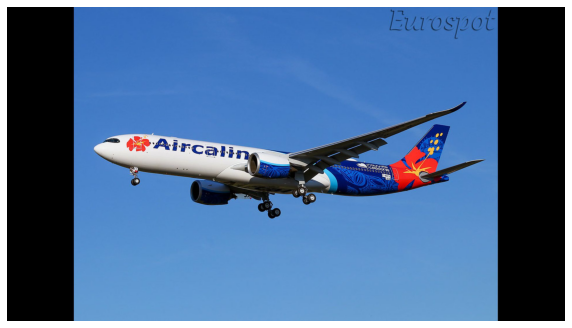

In [ ]:
# загружаем изображение
data = plt.imread(file_list[5])
plt.figure(1, figsize=(10,10))  
  
# выводим изображение
plt.axis('off')
plt.imshow(data)

Загружаем готовые данные в виде numpy массива для обучения на них нейросети.

In [ ]:
All_data = np.load(gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l9/aircraft_np_base.npy', None, quiet=True))
val_split = 0.1 # Коэфициент разделения на обучающую и проверочную выборку

# Перемешаем значения в массиве
np.random.seed(17)
np.random.shuffle(All_data)
np.random.seed(None)

num_val = int(len(All_data) * val_split) # Количество элементов проверочной выборки
num_train = len(All_data) - num_val # Количество элементов обучающей выборки
print (num_val)
print (num_train)
print (All_data.shape)

100
900
(1000,)


Готовые данные представляют из себя массив в котором содержится информация о пути к файлу, его имени и координаты ограничивающей рамки (bounding box)

In [ ]:
All_data[0]

'Airplane/airplane_781.jpg 173,272,1743,783,0'

In [ ]:
All_data.shape

(1000,)

Чтобы путь к фотографиям совпадал, с тем, который закодирован в numpy массиве, фотографии самолетов должны находится в папке Airplane

Код ниже загружает фотографию самолета используя информацию записанную в файле <b>All_data</b>, разбивая ее на две части. До пробела извлекается путь и имя файла фотографии, после пробела координаты рамки (bounding box). Затем строиться изображение, а на нем отображается рамка объекта, после чего изображение с выделенным объектом выводится на экран.

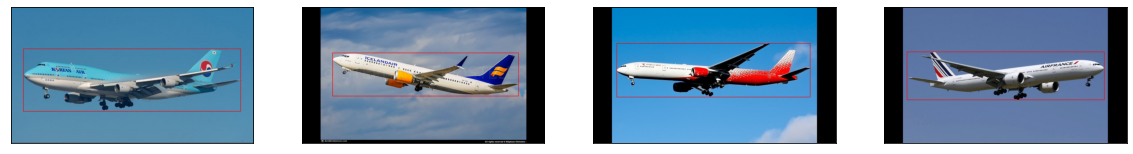

In [ ]:
# Открываем файл сегментированной модели
n_img_show = 4
plt.figure(figsize = (20,15))

for i in range(n_img_show):
  
  file_name, box_coord = All_data[10+i].split(' ')
  minX,minY,maxX,maxY,_ = box_coord.split(',')
  
  # Загружаем изображение сегментированной модели
  image = Image.open('dataset2/airplanes/' + file_name)

  # Создаем экземпляр изображения
  img1 = ImageDraw.Draw(image) 
  img1.rectangle([int(minX),int(minY),int(maxX),int(maxY)], outline = 'red', width=4)
  
  ax=plt.subplot(1,n_img_show,i+1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.imshow(image)

# Рисуем изображение
plt.show() 


# Создание модели Yolo для обучения


In [ ]:
# Определяем сверточный блок с нормализацией и активацией
def DBL(x, filters, kernel, strides=1, batch_norm=True, layer_idx=None): # DarknetConv2D_BN_Leaky
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # Делаем oтступ в виде нулей по контуру изображения, что бы захватить левый верхний угол
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=kernel,
              strides=strides, padding=padding,
              use_bias=not batch_norm, kernel_regularizer=l2(0.0005), name='conv_' + str(layer_idx))(x)
    if batch_norm:
        x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(layer_idx))(x)
        x = LeakyReLU(alpha=0.1,name='leake_' + str(layer_idx))(x)
    return x, layer_idx+1

# Определяем минимальную ячейку Residual блока
def Res_unit(x, filters, layer_idx): # DarknetResidual
    skip_connection = x
    x, layer_idx = DBL(x, filters // 2, kernel=1, layer_idx=layer_idx)
    x, layer_idx = DBL(x, filters, kernel=3, layer_idx=layer_idx)
    x = add([skip_connection , x], name='Add_'+str(layer_idx))
    return x, layer_idx+1   

# Определяем Residual блок состоящий из входного сверточного слоя и последовательности Res_unit блоков
def ResBlock(x, filters, blocks, layer_idx): # DarknetBlock
    x, layer_idx = DBL(x, filters, kernel=3, strides=2, layer_idx=layer_idx)
    for _ in repeat(None, blocks):
        x, layer_idx = Res_unit(x, filters, layer_idx=layer_idx)
    return x, layer_idx   

def Detector(x_in, filters, layer_idx=None):
     if isinstance(x_in, list): # Если на вход поступает список попадаем в эту ветку (маршруты 2 и 3)
        x, x_skip = x_in[0], x_in[1]# Разбиваем список на отдельные тензоры
        x,layer_idx = DBL(x, filters, kernel=1, strides=1, layer_idx=layer_idx) # DarknetConv
        x = UpSampling2D(2, name = 'UpSampling_' + str(layer_idx))(x) # Повышаем размерность тензора
        layer_idx+=1
        x =concatenate([x, x_skip], name = 'Concatenate_' + str(layer_idx)) # Объединяем маршруты
        layer_idx+=1
        # Пять сверточных слоев DBL*5 
        for i in range(2):
          x, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 1,3
          x, layer_idx = DBL(x, filters * 2, 3, layer_idx=layer_idx)  # 2,4
        fork, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 5 С пятого слоя каскада делаем вилку на выход и на другой масштаб         
     else: # В эту ветку попадает только маршрут 1
        x = x_in
        # Пять сверточных слоев DBL*5 
        for i in range(2):
          x, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 1,3
          x, layer_idx = DBL(x, filters * 2, 3, layer_idx=layer_idx)  # 2,4
        fork, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 5 С пятого слоя каскада делаем вилку на выход и на другой масштаб 

     # Выходные слои
     x,layer_idx = DBL(fork, filters=filters*2, kernel=3, strides=1, layer_idx=layer_idx)    # Предпоследний сверточный слой (№80 13х13х1024, #92 26x26x512, #104 52x52x256)
     bboxes, layer_idx = DBL(x, filters=num_sub_anchors * (5+num_classes), kernel=1, strides=1, batch_norm= False, layer_idx=layer_idx)# Выходные слои (№81 13х13х (anchors * (5 + classes)), №93 26х26, №105 52х52 (255)        

     return bboxes, fork, layer_idx

def create_yolov3_model(inputs, num_sub_anchors, num_classes):

    # Так бы выглядела Сеть Darknet 53 если бы ее использовали отдельно    
    layer_idx = 0 # Номер первого слоя
    x, layer_idx = DBL(inputs, filters=32, kernel=3, layer_idx=layer_idx)       # DarknetConv 1 слой
    x, layer_idx = ResBlock(x, filters=64, blocks=1, layer_idx=layer_idx)            # DarknetBlock 3 слоя
    x, layer_idx = ResBlock(x, filters=128, blocks=2, layer_idx=layer_idx)           # DarknetBlock 5 слоя
    x, layer_idx = Route_1,_ = ResBlock(x, filters=256, blocks=8, layer_idx=layer_idx) # DarknetBlock 9 слоев
    x, layer_idx = Route_2,_ = ResBlock(x, filters=512, blocks=8, layer_idx=layer_idx) # DarknetBlock 9 слоев
    Route_3, layer_idx = ResBlock(x, filters=1024, blocks=4, layer_idx=layer_idx)          # последние 4 Res блока Darknet

    bbox_scale_1, fork_1, layer_idx = Detector(Route_3, filters=512, layer_idx=layer_idx) # 5 сверточных слоев DBL

    # 82 слой на первый выход  83 пропуск
    layer_idx = 84
    bbox_scale_2, fork_2, layer_idx = Detector([fork_1, Route_2], filters=256, layer_idx=layer_idx) # 6 слоев
 
    # слои 94-95 пропущены
    layer_idx = 96
    bbox_scale_3, _, layer_idx = Detector([fork_2, Route_1], filters=128, layer_idx=layer_idx) # 6 слоев

    model = Model (inputs, [bbox_scale_1, bbox_scale_2, bbox_scale_3])
    return model


Функция <b>create_model</b> оборачивает модель YOLO для обучения. Мы создаем три входных слоя y_true с формой тезоров ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6) и (None, 52, 52, 3, 6)), где:
<li> Первая позиция (None) - размерность под размер пакета (batch)
<li> Вторая и третья позиции (13, 13) указывают размерность сетки (якорного поля), на которую условно будет разбито входное изображение. Каждый уровень сетки отвечает за обнаружение объектов различных размеров (13 - крупных, 26 - средних, 52 - мелких)
<li>Четвертая позиция - (3)количество анкоров на каждый уровень сетки
<li>Пятая позиция - (6) из них 4 параметра описывающие параметры базового анкора (координаты центра, ширина и высота) +1 вероятность обнаружения объекта + 1 OHE номер класса (так как класс в датасете всего 1)
<p>Функция принимает на вход следующие аргументы:
<li><b>input_shape</b> - размерность входного изображения для модели YOLO
<li><b>num_anchors</b> - общее количество анкоров (9)   
<li><b>use_weights</b> - использовать ли предобученные веса(если модель уже начали обучать)
<li><b>weights_path</b> - путь к сохраненным весам модели  


In [ ]:
def create_model(size, num_anchors, use_weights = False, weights_path = ''):

    inputs = Input(shape = (size, size, 3)) # Создаем входной слой модели, добавляя размерность для глубины цвета
    
    y_true = [Input (shape = (size // 32, size // 32, num_anchors // 3, num_classes + 5))] # Уровень сетки 13х13 (416/32)
    y_true.append (Input (shape = (size // 16, size // 16, num_anchors // 3, num_classes + 5))) # Уровень сетки 26х26 (416/26)
    y_true.append (Input (shape = (size // 8, size // 8, num_anchors // 3, num_classes + 5))) # Уровень сетки 52х52 (416/8)
    
    model_yolo = create_yolov3_model(inputs, num_anchors // 3, num_classes) # Создаем модель YOLOv3
    print ('Создана модель YOLOv3. Количество классов: {}.'.format(num_classes)) # Выводим сообщение о создании модели
    
    # Если установлен флаг загрузки весов
    if use_weights:
        model_yolo.load_weights(weights_path, by_name = False, skip_mismatch = False) # Загружаем предобученные веса
        print ('Загружены веса из файла {}.'.format(weights_path)) # Выводим сообщение о загруженных весах
        
    # Создаем выходной слой Lambda (выходом которого будет значение ошибки модели)
    # На вход слоя подается:
    #   - model_yolo.output (выход модели model_yolo (то есть то, что посчитала сеть))
    #   - y_true (оригинальные данные из обучающей выборки)
    outputs = Lambda(yolo_loss, output_shape = (1,), name = 'yolo_loss', arguments = {'num_anchors' : num_anchors}) ([*model_yolo.output, *y_true])
    
    return Model([inputs, *y_true], outputs) # Возвращаем модель

In [ ]:
size = 416 # Размер входного изображения для модели YOLO
inputs = Input(shape = (size, size, 3)) 
channels= 3
num_sub_anchors=3
weights_path = '/content/yolo_new.h5'
path = '/content/dataset2/airplanes/'
name_classes = ['Самолеты']
num_classes = len(name_classes) # чило классов в новом датасете

anchors = np.array([[10,13], [16,30], [33,23], [30, 61], [62,45], [59,119], [116, 90], [156, 198], [373, 326]])

num_anchors = 9

In [ ]:
# Создаем модель
model_YOLO = create_model(size, num_anchors, use_weights=False, weights_path=weights_path)

Создана модель YOLOv3. Количество классов: 1.


In [ ]:
# Выводим входные размерности для модели
model_YOLO.input

[<KerasTensor: shape=(None, 416, 416, 3) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 13, 13, 3, 6) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 26, 26, 3, 6) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 52, 52, 3, 6) dtype=float32 (created by layer 'input_5')>]

In [ ]:
# Выводим выходныую размерность модели
model_YOLO.output

<KerasTensor: shape=() dtype=float32 (created by layer 'yolo_loss')>

In [ ]:
# Выводим информацию о модели
model_YOLO.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 416, 416, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 416, 416, 32  128         ['conv_0[0][0]']                 
                                )                                                           

In [ ]:
# Компилируем модель
optimizer = Adam(learning_rate=1e-3)
model_YOLO.compile(optimizer=optimizer, loss={'yolo_loss': lambda y_true, y_pred: y_pred})

In [ ]:
# Задаем Колбэки
earlystop=EarlyStopping(monitor='val_loss', mode='min', min_delta=0,patience=7,verbose=1,restore_best_weights=True)
model_Checkpoint = ModelCheckpoint(filepath=weights_path, monitor='val_loss', verbose=1, save_best_only=True,
                               mode='min', baseline=0.5)
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, verbose=1)

In [ ]:
batch_size = 8
input_shape = (416, 416)

In [ ]:
# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit(data_generator(All_data[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(All_data[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size), epochs = 100, verbose = 1, initial_epoch = 0
                   , callbacks=[model_Checkpoint, reduceLROnPlateau])

Epoch 1/100
56/56 [==============================] - 170s 3s/step - loss: 1092.0480 - val_loss: 27092834.0000

Epoch 00001: val_loss improved from inf to 27092834.00000, saving model to /content/drive/My Drive/Модели/yolo_new.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
56/56 [==============================] - 149s 3s/step - loss: 107.9928 - val_loss: 295.7998

Epoch 00002: val_loss improved from 27092834.00000 to 295.79984, saving model to /content/drive/My Drive/Модели/yolo_new.h5
Epoch 3/100
56/56 [==============================] - 147s 3s/step - loss: 61.8294 - val_loss: 104.8834

Epoch 00003: val_loss improved from 295.79984 to 104.88340, saving model to /content/drive/My Drive/Модели/yolo_new.h5
Epoch 4/100
56/56 [==============================] - 149s 3s/step - loss: 45.3666 - val_loss: 58.7993

Epoch 00004: val_loss improved from 104.88340 to 58.79926, saving model to /content/drive/My Drive/Модели/yolo_new.h5
Epoch 5/100
56/56 [==============================] - 150s 3s/step - loss: 36.4762 - val_loss: 44.1465

Epoch 00005: val_loss improved from 58.79926 to 44.14647, saving model to /content/drive/My Drive/Модели/yolo_new.h5
Epoch 6/100
56/56 [==============================] - 145s 3s/step - loss: 34.2210 - val_loss: 34.2881

Epoc

## Тестируем обученную модель

## Функция для обнаружения объект

In [ ]:
def object_detection_2 (filename, model_YOLO, probability=0.7, x_size=12, y_size=17):
    name_classes = ['Самолеты']
    num_classes = len(name_classes)
    anchors = np.array([[10,13], [16,30], [33,23], [30, 61], [62,45], [59,119], [116, 90], [156, 198], [373, 326]])
    image = Image.open(filename) # Загружаем изображение
    # Создаем набор цветов для ограничивающих рамок
    import colorsys 
    hsv_tuples = [(x / len(name_classes), 1., 1.) for x in range(len(name_classes))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x:(int(x[0]*255), int(x[1]*255), int(x[2]*255)), colors))
    np.random.seed(43)
    np.random.shuffle(colors)
    np.random.seed(None)

    # Изменяем размер картинки под input_shape
    iw, ih = image.size
    w, h = (416, 416)
    scale = min(w / iw, h / ih)
    nw = int(iw * scale)
    nh = int(ih * scale)
    image_for_predict = image.resize((nw, nh), Image.BICUBIC)
    new_image = Image.new('RGB', (416,416), (128, 128, 128))
    new_image.paste(image_for_predict, ((w - nw) // 2, (h - nh) // 2))
    image_for_predict = new_image 
    image_for_predict = np.array(image_for_predict) / 255.
    image_for_predict = image_for_predict.reshape(1, 416, 416, 3)

    predict = model_YOLO.predict(image_for_predict)
    num_layers = len(predict) # Получаем количество сеток
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маски для 3 уровней анкоров
    input_shape = np.array(predict[0].shape[1:3]) * 32  # Получаем размер выходного изображения
    image_shape = np.array([image.size[1], image.size[0]]) # Сохраняем размер оригинального изображения

    level_anchor = 0 # Укажем уровень сетки
    num_anchors = len(anchors[anchor_mask[level_anchor]]) # Получаем количество анкоров
    anchors_tensor = np.reshape(anchors[anchor_mask[level_anchor]], (1,1,1,num_anchors,2)) # Выбираем анкоры для нашего уровня сетки и решейпим

    # Создаем пустую сетку
    grid_shape = predict[level_anchor].shape[1:3] # Получим размерность сетки
    grid = [] # Массив для финальной сетки
    grid_row = [] # Массив для столбца
    for i in range(grid_shape[0]): # По всем строкам
      for j in range(grid_shape[1]): # По всем столбцам
        grid_row.append([j , i]) # Создаем элемент [j, i]
      grid.append(grid_row) # Добавляем столбец в финальную сетку
      grid_row = [] # Обнуляем данные для столбца
    grid = np.array(grid) # Переводим в numpy
    grid = np.expand_dims(grid, axis=2) # Добавляем размерность

    # Функция расчета сигмоиды для вектора
    def sigmoid(x): # На вход подаем массив данных
      return 1/(1+np.exp(-x)) # Возвращаем сигмоиду для всех элементов массива

    # Решейпим предикт
    feats = np.reshape(predict[level_anchor], (-1, grid_shape[0], grid_shape[1], num_anchors, num_classes+5))

    # Координаты центра bounding box
    xy_param = feats[..., :2] # Выцепляем 0 и 1 параметры из предикта (соответствуют параметрам смещения центра анкора)
    box_xy = (sigmoid(xy_param) + grid)/grid_shape[::-1] # Получаем координаты центра bounding box

    # Высота и ширна bounding box
    wh_param = feats[..., 2:4] # Выцепляем 2 и 3 параметры из предикта (соответствуют праметрам изменения высоты и ширины анкора)
    box_wh = np.exp(wh_param) * anchors_tensor / input_shape[::-1] # Получаем высоту и ширину bounding box

    # Вероятность наличия объекта в анкоре
    conf_param = feats[..., 4:5] # Выцепляем 4 параметр из предикта (соответствуют вероятности обнаружения объекта)
    box_confidence = sigmoid(conf_param) # Получаем вероятность наличия объекта в bounding box

    # Класс объекта
    class_param = feats[...,5:] # Выцепляем 5+ параметры из предикта (соответствуют вероятностям классов объектов)
    box_class_probs = sigmoid(class_param) # Получаем вероятности классов объектов

    # Корректируем ограничивающие рамки (Размер изображения на выходе 416х416)
    # И найденные параметры соответствуют именно этой размерности
    # Необходимо найти координаты bounding box для рамерности исходного изображения
    box_yx = box_xy[..., ::-1].copy()
    box_hw = box_wh[..., ::-1].copy()

    new_shape = np.round(image_shape * np.min(input_shape/image_shape)) # Находим размерность пропорциональную исходной с одной из сторон 416
    offset = (input_shape-new_shape)/2./input_shape # Смотрим на сколько надо сместить в относительных координатах
    scale = input_shape/new_shape  # Находим коэфициент масштабирования
    box_yx = (box_yx - offset) * scale # Смещаем по координатам
    box_hw *= scale # Масштабируем ширину и высоту

    box_mins = box_yx - (box_hw / 2.) # Получаем левые верхние координаты (от середины отнимаем половину ширины и высоты)
    box_maxes = box_yx + (box_hw / 2.) # Получаем правые нижнние координаты (к середине прибавляем половину ширины и высоты)
    _boxes =  np.concatenate([
    box_mins[..., 0:1], # yMin
    box_mins[..., 1:2], # xMin
    box_maxes[..., 0:1], # yMax
    box_maxes[..., 1:2]  # xMax
    ], axis=-1)

    _boxes *= np.concatenate([image_shape, image_shape]) # Переводим из относительных координат в абсолютные

    # Получаем выходные параметры
    _boxes_reshape = np.reshape(_boxes, (-1, 4)) # Решейпим все боксы в один массив
    _box_scores = box_confidence * box_class_probs # Получаем вероятность каждого класса (умноженную на веоятность наличия объекта)
    _box_scores_reshape = np.reshape(_box_scores, (-1, num_classes)) # Решейпим в один массив

    mask = _box_scores_reshape >= probability # Берем все объекты, обнаруженные с вероятностью больше 0.7
    _boxes_out = _boxes_reshape[mask[:,0]]
    _scores_out = _box_scores_reshape[:, 0][mask[:,0]] 
    classes_out = np.ones_like(_scores_out,'int32') * 0
    font = ImageFont.truetype(font=path + 'font.otf', size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    image_pred = image.copy()
    for i, c in reversed(list(enumerate(classes_out))):
      #print(c)
      draw = ImageDraw.Draw(image_pred)
      predicted_class = name_classes[c]
      box = _boxes_out[i]
      score = _scores_out[i]

      label = '{} {:.2f}'.format(predicted_class, score)
      label_size = draw.textsize(label, font)

      top, left, bottom, right = box
      top = max(0, np.floor(top + 0.5).astype('int32'))
      left = max(0, np.floor(left + 0.5).astype('int32'))
      bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
      right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
      #print(label, (left, top), (right, bottom))

      if top - label_size[1] >= 0:
          text_origin = np.array([left, top - label_size[1]])
      else:
          text_origin = np.array([left, top + 1])
  
      for i in range(thickness):
          draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
      draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
      draw.text(text_origin, label, fill=(0, 0, 0), font=font)
      del draw
    image_pred.save('new_image.jpg')
    plt.figure(figsize=(x_size,y_size))
    plt.imshow(image_pred)

## Тестирование модели на собственных весах

Создаем модель

In [ ]:
yolo3 = create_yolov3_model(Input(shape=(416, 416, 3)), 3, 1)

Загрузим веса из облака  (или можете изменить путь для своего фалйа весов):

In [ ]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l9/yolo_new.h5', None, quiet=True)

'yolo_new.h5'

In [ ]:
yolo3.load_weights('yolo_new.h5')

указываем папку с фотографиями

In [ ]:
source_dir2 = '/content/dataset2/airplanes/Airplane'
# Получаем список путей ко всем файлам с их именами
file_list = get_file_paths(source_dir2+'/**'+ '/*.jpg')
print(len(file_list))

1000


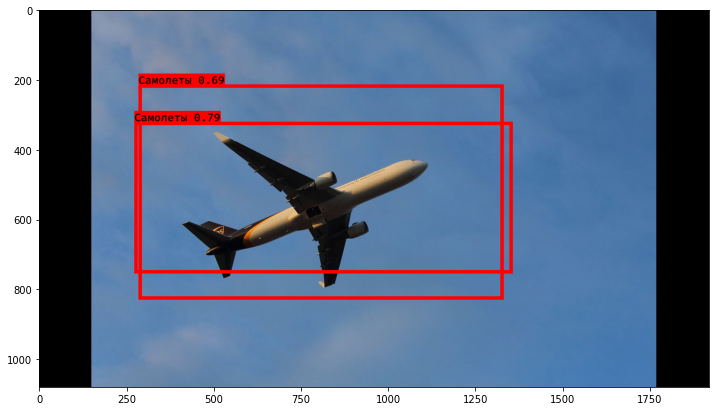

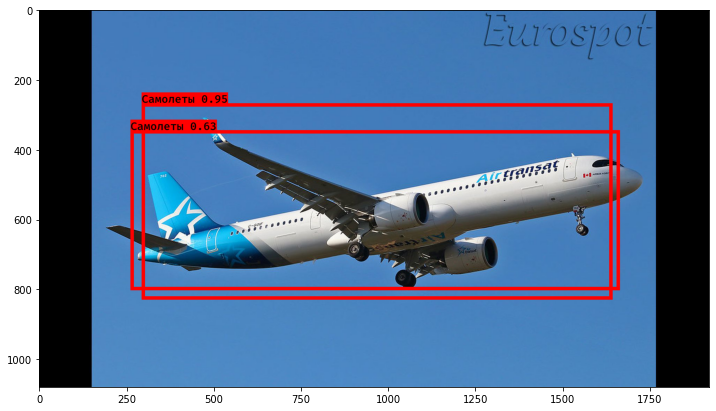

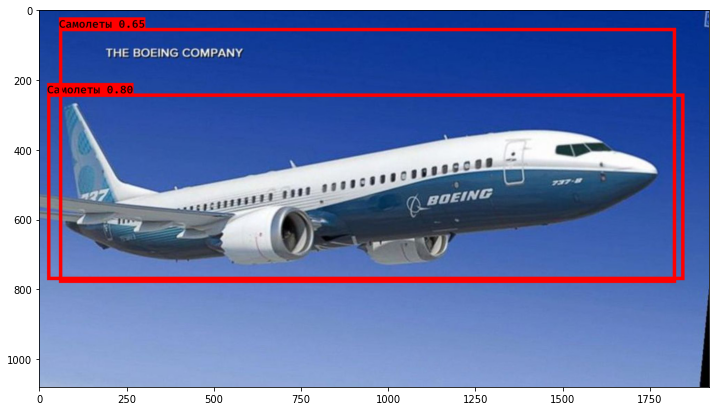

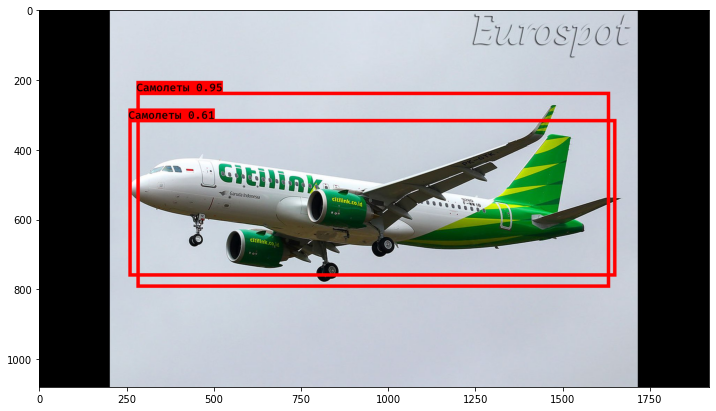

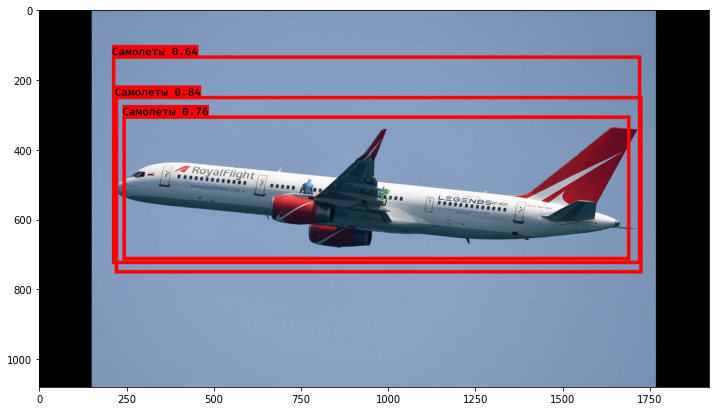

In [ ]:
for i in range(5):
  object_detection_2(file_list[random.randint(0,len(file_list))],yolo3, 0.6)

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1l9jgkXm-RcvY3SE94cZiP_PYxegAoPDa?usp=sharing)
2. [Практический ноутбук 1](https://colab.research.google.com/drive/1dri4Nx0VNsF9vZmF-qjN12AZBJ-eAdlY?usp=sharing)
3. Практический ноутбук 2
